In [18]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

from sklearn.metrics import roc_auc_score, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import timm

from importlib import reload

logging.basicConfig(level=logging.ERROR)

from module import preprocess_lib, datasets_lib, utils_lib, models_lib, learning_lib, config_lib
reload(config_lib)



<module 'module.config_lib' from '/root/program/birdclef-2025/scripts/module/config_lib.py'>

In [24]:
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330' 
            
            # kaggle notebookならここを変更する．
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            self.train_datadir = '../data/raw/train_audio/'
            
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"

            # ローカルならここを変更する．
            self.train_csv = '../data/processed/mel_cleaned_0413/train_with_start_epoch.csv'
            self.spectrogram_npy = '../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy'
            

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5.0 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)

        # ===== Training Mode =====
        if mode == "train":
            self.seed = 42
            self.apex = False
            self.print_freq = 100
            self.num_workers = 2

            self.LOAD_DATA = True
            self.epochs = 10
            self.batch_size = 32
            self.criterion = 'BCEWithLogitsLoss'

            self.n_fold = 5
            self.selected_folds = [0]

            self.optimizer = 'AdamW'
            self.lr = 5e-4
            self.weight_decay = 1e-5
            self.scheduler = 'CosineAnnealingLR'
            self.min_lr = 1e-6
            self.T_max = self.epochs

            
            ## 現状使ってない．
            self.aug_prob = 0.5
            self.mixup_alpha_real = 0.5
            self.mixup_alpha_pseudo = 0.5
            self.use_pseudo_mixup = False  # pseudo lableでmixupするかどうか
            self.pseudo_mix_prob = 0.4  # mixupでpseudo lableを使う確率
            self.pseudo_conf_threshold = 0.5
            self.full_train = False
            ###
            
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            
            
            if self.debug:
                self.epochs = 2
                self.selected_folds = [0]
                self.batch_size = 4
                

In [25]:
cfg = CFG(mode="train", kaggle_notebook=False, debug=False)

In [26]:
utils_lib.set_seed(cfg.seed)

In [27]:
# trainの処理をクラスで実行．
class BirdCLEFTrainer:
    def __init__(self, cfg, df, datasets_lib, models_lib, learning_lib):
        self.cfg = cfg
        self.df = df.head(100).reset_index(drop=True) if cfg.debug else df
        self.datasets_lib = datasets_lib
        self.models_lib = models_lib
        self.learning_lib = learning_lib
        self.spectrograms = None
        self.pseudo_df = None
        self.pseudo_melspecs = None
        self.best_scores = []
        self.train_metrics = {}
        self.val_metrics = {}
        self.label2index = {}
        self.index2label = {}

        self._setup_model_dir()
        self._save_config()
        self._load_taxonomy()
        self._load_spectrograms()
        
        if self.cfg.use_pseudo_mixup:
            self._load_pseudo_data()

    def _setup_model_dir(self):
        if self.cfg.debug:
            current_time = "debug"
            self.cfg.model_path = os.path.join(self.cfg.models_dir, "models_debug")
        else:
            japan_time = datetime.now(timezone(timedelta(hours=9)))
            current_time = japan_time.strftime('%Y%m%d_%H%M')
            self.cfg.model_path = os.path.join(self.cfg.models_dir, f"models_{current_time}")

        os.makedirs(self.cfg.model_path, exist_ok=True)
        print(f"[INFO] Models will be saved to: {self.cfg.model_path}")

        # dataset-metadata.jsonを保存
        dataset_metadata = {
            "title": f"bc25-models-{current_time}",
            "id": f"ihiratch/bc25-models-{current_time}",
            "licenses": [
                {
                    "name": "CC0-1.0"
                }
            ]
        }
        metadata_path = os.path.join(self.cfg.model_path, "dataset-metadata.json")
        with open(metadata_path, "w") as f:
            json.dump(dataset_metadata, f, indent=2)

    def _save_config(self):
        cfg_dict = vars(self.cfg)
        cfg_df = pd.DataFrame(list(cfg_dict.items()), columns=["key", "value"])
        cfg_df.to_csv(os.path.join(self.cfg.model_path, "config.csv"), index=False)

    def _load_taxonomy(self):
        taxonomy_df = pd.read_csv(self.cfg.taxonomy_csv)
        species_ids = taxonomy_df['primary_label'].tolist()
        self.cfg.num_classes = len(species_ids)
        # labelとindexの対応
        self.index2label = {i: label for i, label in enumerate(species_ids)}
        self.label2index = {label: i for i, label in enumerate(species_ids)}

    def _load_spectrograms(self):
        print(f"Loading pre-computed mel spectrograms from NPY file, from the path: {self.cfg.spectrogram_npy}")
        self.spectrograms = np.load(self.cfg.spectrogram_npy, allow_pickle=True).item()
        print(f"Loaded {len(self.spectrograms)} pre-computed mel spectrograms")
        
    def _load_pseudo_data(self):
        print("📥 Loading pseudo label CSV and melspecs...")

        # row_id を index にして読み込む（← ここがポイント！）
        self.pseudo_df = pd.read_csv(self.cfg.pseudo_label_csv, index_col="row_id")

        # 信頼度フィルタリング（例: 最大値が 0.5 未満の行を除く）
        confidence_threshold = self.cfg.pseudo_conf_threshold
        max_probs = self.pseudo_df.max(axis=1)
        self.pseudo_df = self.pseudo_df[max_probs > confidence_threshold]
        self.pseudo_df = self.pseudo_df.reset_index(drop=False)
        print(f"✅ Filtered pseudo labels: {len(self.pseudo_df)}")

        # melspec は key が row_id の dict を想定
        self.pseudo_melspecs = np.load(self.cfg.pseudo_melspec_npy, allow_pickle=True)
        print(f"✅ Loaded pseudo mel-spectrograms: {len(self.pseudo_melspecs)}")
        
    def _create_train_dataset(self, train_df):
        if self.cfg.use_pseudo_mixup:
            print("🔀 Using BirdCLEFDatasetWithPseudo (with pseudo label mixup)")
            return self.datasets_lib.BirdCLEFDatasetWithPseudo(
                train_df=train_df,
                pseudo_df=self.pseudo_df,
                cfg=self.cfg,
                spectrograms=self.spectrograms,
                pseudo_melspecs=self.pseudo_melspecs,
                mode='train'
            )
        else:
            print("📦 Using BirdCLEFDatasetFromNPY (no pseudo mixup)")
            return self.datasets_lib.BirdCLEFDatasetFromNPY(
                train_df, self.cfg, self.spectrograms, mode='train'
            )   

    def _calculate_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # 👇 ROC AUC はバイナリラベルを必要とするので、soft labelを2値化
        targets_bin = (targets >= 0.5).astype(int)

        aucs = [roc_auc_score(targets_bin[:, i], probs[:, i]) 
                for i in range(targets.shape[1]) if np.sum(targets_bin[:, i]) > 0]
        return np.mean(aucs) if aucs else 0.0

    def _calculate_classwise_auc(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # バイナリ化（連続値でもintでも安全）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_auc = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_auc[i] = roc_auc_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_auc[i] = np.nan  # エラー出たときも安心
        return classwise_auc

    def _calculate_classwise_ap(self, targets, outputs):
        probs = 1 / (1 + np.exp(-outputs))

        # ラベルをバイナリ化（soft label対応）
        targets_bin = (targets >= 0.5).astype(int)

        classwise_ap = {}
        for i in range(targets.shape[1]):
            if np.sum(targets_bin[:, i]) > 0:
                try:
                    classwise_ap[i] = average_precision_score(targets_bin[:, i], probs[:, i])
                except ValueError:
                    classwise_ap[i] = np.nan
        return classwise_ap
    
    def _calculate_map(self, targets, outputs):
        classwise_ap = self._calculate_classwise_ap(targets, outputs)
        values = [v for v in classwise_ap.values() if v is not None and not np.isnan(v)]
        return np.mean(values) if values else 0.0

    def _save_classwise_scores_to_csv(self, classwise_auc, classwise_ap, fold, filename_prefix):
        rows = []
        for i in classwise_auc:
            label = self.index2label.get(i, str(i))
            auc = classwise_auc[i]
            ap = classwise_ap.get(i, np.nan)
            rows.append({"label": label, "val_auc": auc, "val_ap": ap})
        df = pd.DataFrame(rows)
        df.to_csv(os.path.join(self.cfg.model_path, f"{filename_prefix}_classwise_score_fold{fold}.csv"), index=False)


    def train_one_epoch(self, model, loader, optimizer, criterion, device, scheduler=None):
        model.train()
        losses, all_targets, all_outputs = [], [], []

        pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
        for step, batch in pbar:
            if isinstance(batch['melspec'], list):
                batch_outputs, batch_losses = [], []
                for i in range(len(batch['melspec'])):
                    inputs = batch['melspec'][i].unsqueeze(0).to(device)
                    target = batch['target'][i].unsqueeze(0).to(device)
                    optimizer.zero_grad()
            
                    output = model(inputs)
                    loss = criterion(output, target)
                    loss.backward()
                    batch_outputs.append(output.detach().cpu())
                    batch_losses.append(loss.item())
                optimizer.step()
                outputs = torch.cat(batch_outputs, dim=0).numpy()
                loss = np.mean(batch_losses)
                targets = batch['target'].numpy()
            else:
                inputs = batch['melspec'].to(device)
                targets = batch['target'].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = outputs[1] if isinstance(outputs, tuple) else criterion(outputs, targets)
                outputs = outputs[0] if isinstance(outputs, tuple) else outputs
                loss.backward()
                optimizer.step()
                outputs = outputs.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()

            if scheduler and isinstance(scheduler, lr_scheduler.OneCycleLR):
                scheduler.step()

            all_outputs.append(outputs)
            all_targets.append(targets)
            losses.append(loss.item() if not isinstance(loss, float) else loss)

            pbar.set_postfix({
                'train_loss': np.mean(losses[-10:]) if losses else 0,
                'lr': optimizer.param_groups[0]['lr']
            })

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        self.train_metrics = {
            'train_loss': np.mean(losses),
            'train_auc': self._calculate_auc(all_targets, all_outputs),
            "train_map": self._calculate_map(all_targets, all_outputs),   
            "train_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "train_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),  
        }

    def validate(self, model, loader, criterion, device):
        model.eval()
        losses, all_targets, all_outputs = [], [], []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Validation"):
                if isinstance(batch['melspec'], list):
                    batch_outputs, batch_losses = [], []
                    for i in range(len(batch['melspec'])):
                        inputs = batch['melspec'][i].unsqueeze(0).to(device)
                        target = batch['target'][i].unsqueeze(0).to(device)
                        output = model(inputs)
                        loss = criterion(output, target)
                        batch_outputs.append(output.detach().cpu())
                        batch_losses.append(loss.item())
                    outputs = torch.cat(batch_outputs, dim=0).numpy()
                    loss = np.mean(batch_losses)
                    targets = batch['target'].numpy()
                else:
                    inputs = batch['melspec'].to(device)
                    targets = batch['target'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    outputs = outputs.detach().cpu().numpy()
                    targets = targets.detach().cpu().numpy()

                all_outputs.append(outputs)
                all_targets.append(targets)
                losses.append(loss.item() if not isinstance(loss, float) else loss)

        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)
        # print("Size of validation:",  len(all_targets))
        self.val_metrics = {
            'val_loss': np.mean(losses),
            'val_auc': self._calculate_auc(all_targets, all_outputs),
            "val_map": self._calculate_map(all_targets, all_outputs),
            "val_classwise_auc": self._calculate_classwise_auc(all_targets, all_outputs),
            "val_classwise_ap": self._calculate_classwise_ap(all_targets, all_outputs),
        }

    def run(self):
        
        for fold in range(self.cfg.n_fold):
            if fold not in self.cfg.selected_folds:
                continue
            print(f"\n{'='*30} Fold {fold} {'='*30}")

            # train.csvのfoldを使う．
            
            if self.cfg.full_train:
                train_df = self.df.reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True)
                print("Use full train data for training.")
            else:
                train_df = self.df[self.df['fold'] != fold].reset_index(drop=True)
                val_df = self.df[self.df['fold'] == fold].reset_index(drop=True) 
            
            print(f"Training set: {len(train_df)} samples")
            print(f"Validation set: {len(val_df)} samples")

            train_dataset = self._create_train_dataset(train_df)
            val_dataset = self.datasets_lib.BirdCLEFDatasetFromNPY(
                val_df, self.cfg, self.spectrograms, mode='valid'
            )

            val_loader = DataLoader(val_dataset, batch_size=self.cfg.batch_size, shuffle=False,
                                     num_workers=self.cfg.num_workers, pin_memory=True,
                                     collate_fn=self.datasets_lib.collate_fn)

            model = self.models_lib.BirdCLEFModelForTrain(self.cfg).to(self.cfg.device)
            optimizer = self.learning_lib.get_optimizer(model, self.cfg)
            criterion = self.learning_lib.get_criterion(self.cfg)

            scheduler = (lr_scheduler.OneCycleLR(optimizer, max_lr=self.cfg.lr, 
                        steps_per_epoch=len(train_loader), epochs=self.cfg.epochs, pct_start=0.1)
                         if self.cfg.scheduler == 'OneCycleLR'
                         else self.learning_lib.get_scheduler(optimizer, self.cfg))

            best_auc = 0
            log_history = []

            for epoch in range(self.cfg.epochs):
                print(f"\nEpoch {epoch+1}/{self.cfg.epochs}")
                start_time = time.time()
                
                # curriculum learningの実装
                # ✅ start_epoch ≤ epoch のサンプルを抽出
                allowed_indices = train_df[train_df["start_epoch"] <= (epoch + 1)].index.tolist()
                print(f"Using {len(allowed_indices)} training samples this epoch...")
                train_sampler = SubsetRandomSampler(allowed_indices)

                train_loader = DataLoader(
                    train_dataset,
                    sampler=train_sampler,
                    batch_size=self.cfg.batch_size,
                    num_workers=self.cfg.num_workers,
                    collate_fn=self.datasets_lib.collate_fn,
                    drop_last=True,
                    pin_memory=True
                )

                self.train_one_epoch(model, train_loader, optimizer, criterion, self.cfg.device,
                                    scheduler if isinstance(scheduler, lr_scheduler.OneCycleLR) else None)
                self.validate(model, val_loader, criterion, self.cfg.device)

                # スコア取得
                train_loss = self.train_metrics['train_loss']
                train_auc = self.train_metrics['train_auc']
                train_auc_map = self.train_metrics['train_map']

                val_loss = self.val_metrics['val_loss']
                val_auc = self.val_metrics['val_auc']
                val_auc_map = self.val_metrics['val_map']
                val_classwise_auc = self.val_metrics['val_classwise_auc']
                val_classwise_ap = self.val_metrics['val_classwise_ap']

                if scheduler and not isinstance(scheduler, lr_scheduler.OneCycleLR):
                    scheduler.step(val_loss if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau) else None)

                print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train MAP: {train_auc_map:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val MAP: {val_auc_map:.4f}")

                if val_auc > best_auc:
                    best_auc = val_auc
                    print(f"New best AUC: {best_auc:.4f} at epoch {epoch+1}")
                    
                    self._save_classwise_scores_to_csv(val_classwise_auc, val_classwise_ap, fold, filename_prefix="best_val")

                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                        'epoch': epoch,
                        'val_auc': val_auc,
                        'train_auc': train_auc,
                        "index2label": self.index2label,
                        'cfg': self.cfg
                    }, f"{self.cfg.model_path}/model_fold{fold}.pth")

                log_entry = {
                    'epoch': epoch + 1,
                    'lr': scheduler.get_last_lr()[0] if scheduler else self.cfg.lr,
                    'epoch_time_min': round((time.time() - start_time) / 60, 2)
                }

                # classwiseスコアを除外した val_metrics のログ
                train_log = {f"{k}": v for k, v in self.train_metrics.items() if not k.startswith("train_classwise")}
                val_log = {f"{k}": v for k, v in self.val_metrics.items() if not k.startswith("val_classwise")}
                
                # ログ用スコアの更新（classwiseは除外）
                log_entry.update(train_log)
                log_entry.update(val_log)
                log_history.append(log_entry)
            
           
                

            pd.DataFrame(log_history).to_csv(f"{self.cfg.model_path}/log_fold{fold}.csv", index=False)
            self.best_scores.append(best_auc)
            print(f"\nBest AUC for fold {fold}: {best_auc:.4f}")

            del model, optimizer, scheduler, train_loader, val_loader
            torch.cuda.empty_cache()
            gc.collect()

        print("\n" + "="*60)
        print("Cross-Validation Results:")
        for fold, score in enumerate(self.best_scores):
            print(f"Fold {self.cfg.selected_folds[fold]}: {score:.4f}")
        print(f"Mean AUC: {np.mean(self.best_scores):.4f}")
        print("="*60)



In [28]:
# モデルはmodels_{current_time}に保存される．
if __name__ == "__main__":
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)  # これはtrainer内部でまた読み込むので optional

    print("\nStarting training...")
    trainer = BirdCLEFTrainer(cfg, train_df, datasets_lib, models_lib, learning_lib)
    trainer.run()
    print("\nTraining complete!")


Loading training data...

Starting training...
[INFO] Models will be saved to: ../models/models_20250419_2123
Loading pre-computed mel spectrograms from NPY file, from the path: ../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy
Loaded 28564 pre-computed mel spectrograms

============================== Fold 0 ==============================
Training set: 22851 samples
Validation set: 5713 samples
📦 Using BirdCLEFDatasetFromNPY (no pseudo mixup)
Found 22851 matching spectrograms for train dataset out of 22851 samples
Found 5713 matching spectrograms for valid dataset out of 5713 samples

Epoch 1/10
Using 9652 training samples this epoch...


Training:   0%|          | 0/301 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0394, Train AUC: 0.5186, Train MAP: 0.0214
Val Loss: 0.0351, Val AUC: 0.5861, Val MAP: 0.0217
New best AUC: 0.5861 at epoch 1

Epoch 2/10
Using 14700 training samples this epoch...


Training:   0%|          | 0/459 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0208, Train AUC: 0.6814, Train MAP: 0.0870
Val Loss: 0.0282, Val AUC: 0.6829, Val MAP: 0.0955
New best AUC: 0.6829 at epoch 2

Epoch 3/10
Using 17768 training samples this epoch...


Training:   0%|          | 0/555 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0184, Train AUC: 0.7955, Train MAP: 0.1816
Val Loss: 0.0241, Val AUC: 0.7381, Val MAP: 0.1623
New best AUC: 0.7381 at epoch 3

Epoch 4/10
Using 19831 training samples this epoch...


Training:   0%|          | 0/619 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0171, Train AUC: 0.8569, Train MAP: 0.2641
Val Loss: 0.0210, Val AUC: 0.7802, Val MAP: 0.2247
New best AUC: 0.7802 at epoch 4

Epoch 5/10
Using 21257 training samples this epoch...


Training:   0%|          | 0/664 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0160, Train AUC: 0.8961, Train MAP: 0.3372
Val Loss: 0.0187, Val AUC: 0.8244, Val MAP: 0.2878
New best AUC: 0.8244 at epoch 5

Epoch 6/10
Using 22203 training samples this epoch...


Training:   0%|          | 0/693 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0147, Train AUC: 0.9306, Train MAP: 0.4125
Val Loss: 0.0167, Val AUC: 0.8706, Val MAP: 0.3533
New best AUC: 0.8706 at epoch 6

Epoch 7/10
Using 22656 training samples this epoch...


Training:   0%|          | 0/708 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0132, Train AUC: 0.9391, Train MAP: 0.4570
Val Loss: 0.0161, Val AUC: 0.9016, Val MAP: 0.3968
New best AUC: 0.9016 at epoch 7

Epoch 8/10
Using 22803 training samples this epoch...


Training:   0%|          | 0/712 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0116, Train AUC: 0.9494, Train MAP: 0.4779
Val Loss: 0.0158, Val AUC: 0.9290, Val MAP: 0.4141
New best AUC: 0.9290 at epoch 8

Epoch 9/10
Using 22849 training samples this epoch...


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0104, Train AUC: 0.9518, Train MAP: 0.4799
Val Loss: 0.0156, Val AUC: 0.9358, Val MAP: 0.4309
New best AUC: 0.9358 at epoch 9

Epoch 10/10
Using 22851 training samples this epoch...


Training:   0%|          | 0/714 [00:00<?, ?it/s]

Validation:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0097, Train AUC: 0.9671, Train MAP: 0.5104
Val Loss: 0.0158, Val AUC: 0.9366, Val MAP: 0.4356
New best AUC: 0.9366 at epoch 10

Best AUC for fold 0: 0.9366

Cross-Validation Results:
Fold 0: 0.9366
Mean AUC: 0.9366

Training complete!


In [9]:
import pandas as pd
import math

def assign_start_epoch(df, min_epoch: int = 1, max_epoch: int = 10):
    """
    各 primary_label に基づいて、1〜10の start_epoch を割り当てる。
    データ数が多い種は早く学習に含める。

    Parameters:
    - df: train.csv の DataFrame
    - min_epoch: 最も早く学習に含まれるエポック（デフォルト 1）
    - max_epoch: 最も遅く学習に含まれるエポック（デフォルト 10）

    Returns:
    - start_epoch カラムが追加された DataFrame
    """
    # 種ごとの出現回数
    species_counts = df['primary_label'].value_counts()
    
    # 多い順に並べて簡単な順に並べる
    sorted_species = species_counts.sort_values(ascending=False).index.tolist()
    num_species = len(sorted_species)
    
    # start_epoch の割り当て：簡単な種 = 1, 難しい種 = 10
    species2start = {
        species: int(min_epoch + (i / (num_species - 1)) * (max_epoch - min_epoch))
        for i, species in enumerate(sorted_species)
    }

    # 割り当て
    df['start_epoch'] = df['primary_label'].map(species2start)
    
    return df



In [12]:
df = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

# start_epoch を 0〜6 に割り当て
df = assign_start_epoch(df, max_epoch=10)
df.to_csv("../data/processed/mel_cleaned_0413/train_with_start_epoch.csv", index=False)

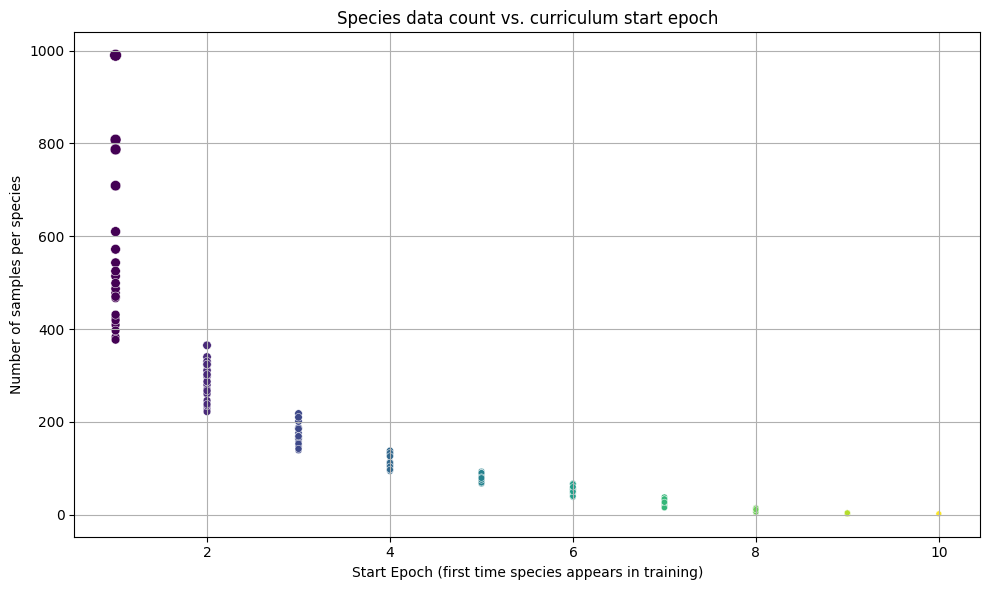

In [13]:
# 種ごとのデータ数と start_epoch をまとめる
species_stats = df.groupby("primary_label").agg(
    count=("primary_label", "count"),
    start_epoch=("start_epoch", "min")
).reset_index()

# 可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=species_stats,
    x="start_epoch",
    y="count",
    size="count",
    hue="start_epoch",
    palette="viridis",
    legend=False
)
plt.xlabel("Start Epoch (first time species appears in training)")
plt.ylabel("Number of samples per species")
plt.title("Species data count vs. curriculum start epoch")
plt.grid(True)
plt.tight_layout()
plt.show()